1.Tokenizer的示例

In [41]:
from transformers import BertTokenizer

# 加载中文 BERT 分词器
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

# 示例长文本
text = (
    "Transformer 是一种基于自注意力机制的模型架构，广泛应用于自然语言处理任务。"
    "与传统的循环神经网络不同，它能够并行处理整个序列，并捕捉长距离依赖。"
    "本文将介绍其基本组成部分，包括词嵌入、位置编码、自注意力、前馈网络等。"
)

# 编码
encoded = tokenizer(
    text,
    return_tensors="pt",        # 返回 PyTorch tensor 格式
    padding=True,               # 自动填充
    truncation=True,            # 超过最大长度则截断
    max_length=8192           # 设置最大 token 长度
)

# 解码：将 input_ids 转回文本
tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
decoded_text = tokenizer.decode(encoded["input_ids"][0], skip_special_tokens=True)

# 打印格式优化
print("\n原始输入文本：")
print(text)

print("\n--- 编码后的结果 ---")
print("input_ids（Token ID 序列）：")
print(encoded["input_ids"])
print("\ntoken_type_ids（句子对标识）：")
print(encoded["token_type_ids"])
print("\nattention_mask（注意力掩码）：")
print(encoded["attention_mask"])

print("\n--- 分词结果 ---")
print("Tokens（按顺序显示）：")
print(tokens)

print("\n解码回原句（去除特殊符号）：")
print(decoded_text)



原始输入文本：
Transformer 是一种基于自注意力机制的模型架构，广泛应用于自然语言处理任务。与传统的循环神经网络不同，它能够并行处理整个序列，并捕捉长距离依赖。本文将介绍其基本组成部分，包括词嵌入、位置编码、自注意力、前馈网络等。

--- 编码后的结果 ---
input_ids（Token ID 序列）：
tensor([[ 101,  100, 3221,  671, 4905, 1825,  754, 5632, 3800, 2692, 1213, 3322,
         1169, 4638, 3563, 1798, 3373, 3354, 8024, 2408, 3793, 2418, 4500,  754,
         5632, 4197, 6427, 6241, 1905, 4415,  818, 1218,  511,  680,  837, 5320,
         4638, 2542, 4384, 4868, 5307, 5381, 5317,  679, 1398, 8024, 2124, 5543,
         1916, 2400, 6121, 1905, 4415, 3146,  702, 2415, 1154, 8024, 2400, 2936,
         2929, 7270, 6655, 4895,  898, 6609,  511, 3315, 3152, 2199,  792, 5305,
         1071, 1825, 3315, 5299, 2768, 6956, 1146, 8024, 1259, 2886, 6404, 2316,
         1057,  510,  855, 5390, 5356, 4772,  510, 5632, 3800, 2692, 1213,  510,
         1184, 7668, 5381, 5317, 5023,  511,  102]])

token_type_ids（句子对标识）：
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0,

2.embedding

In [42]:
from transformers import BertModel
import torch

# 加载 BERT 模型（包含嵌入层）
model = BertModel.from_pretrained("bert-base-chinese")

# 禁用梯度计算，节省资源（不训练）
with torch.no_grad():
    outputs = model(**encoded)

# 输出说明：
# outputs.last_hidden_state 是每个 token 对应的嵌入向量（包含上下文）
embeddings = outputs.last_hidden_state  # shape: [batch_size, seq_len, hidden_size]

# 查看形状
print("\n--- 词嵌入向量 ---")
print(f"嵌入向量形状：{embeddings.shape}  （格式：batch_size × token数 × 向量维度）")

# 示例：打印前20个 token 的向量（每个是 768 维）
for i, token in enumerate(tokens[:20]):
    print(f"\nToken: {token}")
    print(f"向量（截取前50维）：{embeddings[0, i, :50].tolist()}")



--- 词嵌入向量 ---
嵌入向量形状：torch.Size([1, 103, 768])  （格式：batch_size × token数 × 向量维度）

Token: [CLS]
向量（截取前50维）：[1.3844170570373535, -0.25831639766693115, -0.20382636785507202, 0.41605859994888306, 0.9391679167747498, -0.6493721008300781, -0.5601017475128174, -0.48804324865341187, -0.6326172351837158, 0.4762522876262665, -1.2265592813491821, 0.3223559856414795, -0.31468716263771057, -0.7320123910903931, 1.8411892652511597, -0.6561687588691711, 0.6813036203384399, -0.5797879099845886, -0.6929993033409119, -0.3496723473072052, -0.9756779074668884, -0.0206417515873909, 1.0321036577224731, 0.08078744262456894, 0.3291874825954437, 0.9719803929328918, 0.20414716005325317, -0.5813137888908386, 1.160369634628296, -0.5142177939414978, 0.28890717029571533, -0.7470093965530396, -0.05369122326374054, -0.21911939978599548, 1.2121516466140747, -0.3649604320526123, -2.3722000122070312, 0.3653334975242615, 0.17875570058822632, -0.11243551969528198, 0.05200142413377762, -0.2321474552154541, -0.48800185322761

3.1
位置编码（Positional
Encoding）与词嵌入相加


In [45]:
import math


def get_positional_encoding(seq_len, dim, device="cpu"):
    """
    正余弦位置编码实现，与 Transformer 原论文一致
    :param seq_len: 序列长度
    :param dim: 向量维度（必须与嵌入维度一致）
    :return: [1, seq_len, dim] 的位置编码张量
    """
    pe = torch.zeros(seq_len, dim).to(device)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))

    pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维
    pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维

    return pe.unsqueeze(0)  # 添加 batch_size 维度，shape: [1, seq_len, dim]


# 生成并添加位置编码
seq_len = embeddings.shape[1]
dim = embeddings.shape[2]
pos_encoding = get_positional_encoding(seq_len, dim, device=embeddings.device)

# 相加：词向量 + 位置编码
embeddings_with_pos = embeddings + pos_encoding

3.2打印含位置编码后的表示

In [46]:
# 示例：打印前 5 个 token 的“最终表示向量”（含位置信息）
for i, token in enumerate(tokens[:5]):
    print(f"\nToken: {token}")
    print(f"加入位置编码后的向量（前 10 维）：{embeddings_with_pos[0, i, :10].tolist()}")



Token: [CLS]
加入位置编码后的向量（前 10 维）：[1.3844170570373535, 0.7416836023330688, -0.20382636785507202, 1.4160585403442383, 0.9391679167747498, 0.3506278991699219, -0.5601017475128174, 0.5119567513465881, -0.6326172351837158, 1.4762523174285889]

Token: [UNK]
加入位置编码后的向量（前 10 维）：[1.3272266387939453, 0.812993049621582, 1.2566884756088257, 0.9471114277839661, 0.8746529817581177, -0.5208663940429688, 0.6367738842964172, 0.6569143533706665, -0.8646963834762573, 1.2513511180877686]

Token: 是
加入位置编码后的向量（前 10 维）：[1.087563157081604, -1.1051223278045654, 0.8902108669281006, -0.5128674507141113, 2.386169910430908, 0.612694501876831, 0.36566030979156494, -0.7413132190704346, 0.5992742776870728, -0.8112227916717529]

Token: 一
加入位置编码后的向量（前 10 维）：[0.16350334882736206, -1.2227036952972412, -0.08104856312274933, -0.8513468503952026, 1.4927089214324951, -0.7923214435577393, 0.036114275455474854, -0.6573208570480347, 0.05811256170272827, -0.33448922634124756]

Token: 种
加入位置编码后的向量（前 10 维）：[-0.8651281595230103, -0

5.K,Q,V矩阵的生成和变换过程

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# 设置随机种子，保证实验可复现
torch.manual_seed(42)

# 定义一个简单的自注意力模块
class SimpleAttention(nn.Module):
    def __init__(self, input_dim, proj_dim):
        super().__init__()
        # W_Q, W_K, W_V 是通过线性层生成的
        self.W_Q = nn.Linear(input_dim, proj_dim)  # Query 映射
        self.W_K = nn.Linear(input_dim, proj_dim)  # Key 映射
        self.W_V = nn.Linear(input_dim, proj_dim)  # Value 映射
        self.out = nn.Linear(proj_dim, 1)          # 输出层（用于简化任务）

    def forward(self, x):
        # 生成 Q、K、V 向量
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        # 计算注意力分数（缩放点积注意力）
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1)**0.5)
        weights = torch.softmax(scores, dim=-1)       # 归一化为注意力权重
        context = torch.matmul(weights, V)            # 根据权重加权求和 Value

        # 将上下文信息池化后输出
        return self.out(context.mean(dim=1))  # 平均池化作为最终表示

# 模拟两个样本：每个样本包含3个词，每个词是4维嵌入
X = torch.randn(2, 3, 4)
y = torch.tensor([[1.0], [0.0]])  # 假设的目标输出

# 初始化模型
model = SimpleAttention(input_dim=4, proj_dim=3)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# 保存训练前的参数权重
initial_WQ = model.W_Q.weight.data.clone()
initial_WK = model.W_K.weight.data.clone()
initial_WV = model.W_V.weight.data.clone()

# 训练模型 20 步
for epoch in range(20):
    optimizer.zero_grad()
    output = model(X)                # 前向传播
    loss = loss_fn(output, y)       # 计算损失
    loss.backward()                 # 反向传播
    optimizer.step()                # 参数更新
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# 输出训练前后 W_Q 的变化
print("\n初始 W_Q:")
print(initial_WQ)
print("训练后 W_Q:")
print(model.W_Q.weight.data)

print("\n初始 W_K:")
print(initial_WK)
print("训练后 W_K:")
print(model.W_K.weight.data)

print("\n初始 W_V:")
print(initial_WV)
print("训练后 W_V:")
print(model.W_V.weight.data)


Epoch 1: Loss = 1.7862
Epoch 2: Loss = 1.6117
Epoch 3: Loss = 1.4567
Epoch 4: Loss = 1.3198
Epoch 5: Loss = 1.1993
Epoch 6: Loss = 1.0938
Epoch 7: Loss = 1.0016
Epoch 8: Loss = 0.9211
Epoch 9: Loss = 0.8508
Epoch 10: Loss = 0.7894
Epoch 11: Loss = 0.7355
Epoch 12: Loss = 0.6880
Epoch 13: Loss = 0.6458
Epoch 14: Loss = 0.6080
Epoch 15: Loss = 0.5738
Epoch 16: Loss = 0.5425
Epoch 17: Loss = 0.5137
Epoch 18: Loss = 0.4869
Epoch 19: Loss = 0.4618
Epoch 20: Loss = 0.4381

初始 W_Q:
tensor([[ 0.1343, -0.1356,  0.2104,  0.4464],
        [ 0.2890, -0.2186,  0.2886,  0.0895],
        [ 0.2539, -0.3048, -0.4950, -0.1932]])
训练后 W_Q:
tensor([[ 0.0748, -0.2188,  0.1299,  0.4619],
        [ 0.4518, -0.3880,  0.3979, -0.0676],
        [ 0.4217, -0.4694, -0.3718, -0.3555]])

初始 W_K:
tensor([[ 0.2071,  0.1581, -0.0087,  0.3913],
        [-0.3553,  0.0315, -0.3413,  0.1542],
        [-0.1722,  0.1532, -0.1042,  0.4147]])
训练后 W_K:
tensor([[ 0.3521,  0.3003,  0.1374,  0.2428],
        [-0.5168, -0.1281, -0.

6.多头注意力机制的实现

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
import math

# ----------------------------
# 自注意力模块（支持多头）并返回注意力矩阵
# ----------------------------
class SelfAttentionLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(SelfAttentionLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        return x.permute(0, 2, 1, 3)

    def forward(self, x):
        batch_size, seq_len, d_model = x.size()
        q = self.split_heads(self.W_q(x), batch_size)
        k = self.split_heads(self.W_k(x), batch_size)
        v = self.split_heads(self.W_v(x), batch_size)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_k ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_weights, v)

        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, -1)

        return output, attn_weights  # 返回输出和注意力矩阵


# ----------------------------
# 主流程：文本 → 编码 → 嵌入 → 自注意力
# ----------------------------

# Step 1: 输入中文句子
text = "我喜欢深度学习，尤其是注意力机制。"

# Step 2: 分词 + 编码
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
encoded = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64)
tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])

# Step 3: 获取词嵌入
bert = BertModel.from_pretrained("bert-base-chinese")
with torch.no_grad():
    embedding = bert(**encoded).last_hidden_state  # shape: [1, seq_len, 768]

# Step 4: 位置编码
def get_positional_encoding(seq_len, dim, device="cpu"):
    pe = torch.zeros(seq_len, dim).to(device)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)

seq_len, dim = embedding.shape[1], embedding.shape[2]
pos_enc = get_positional_encoding(seq_len, dim, embedding.device)
embedding_with_pos = embedding + pos_enc

# Step 5: 自注意力模块
self_attn = SelfAttentionLayer(d_model=dim, num_heads=8)
output, attn_weights = self_attn(embedding_with_pos)  # [1, seq_len, 768], [1, heads, seq_len, seq_len]

# Step 6: 打印结果
print(f"\n原始文本: {text}")
print(f"分词结果: {tokens}")
print(f"输出张量形状: {output.shape}")

# 查看前 3 个 token 的输出向量
for i in range(min(3, seq_len)):
    print(f"\nToken: {tokens[i]}")
    print(f"注意力输出（前 10 维）：{output[0, i, :10].tolist()}")

# 打印注意力矩阵：只看第一个头
print(f"\n注意力矩阵（第 1 个头）形状: {attn_weights.shape}")
print("注意力矩阵（前 5 个 token 对前 10 个 token 的关注）：")
for i in range(min(5, seq_len)):
    row = attn_weights[0, 0, i, :seq_len].tolist()
    print(f"{tokens[i]: <6} → {[round(x, 3) for x in row[:10]]}")



原始文本: 我喜欢深度学习，尤其是注意力机制。
分词结果: ['[CLS]', '我', '喜', '欢', '深', '度', '学', '习', '，', '尤', '其', '是', '注', '意', '力', '机', '制', '。', '[SEP]']
输出张量形状: torch.Size([1, 19, 768])

Token: [CLS]
注意力输出（前 10 维）：[-0.01589636690914631, 0.2531856298446655, 0.5434309244155884, 0.43369171023368835, 0.04267208278179169, -0.15239012241363525, -0.15513049066066742, 0.09602845460176468, -0.6848487257957458, -0.5442842245101929]

Token: 我
注意力输出（前 10 维）：[-0.010717901401221752, 0.2231217324733734, 0.5190502405166626, 0.4270201027393341, 0.06346976011991501, -0.15483607351779938, -0.13781876862049103, 0.12402065843343735, -0.7052809000015259, -0.5382952690124512]

Token: 喜
注意力输出（前 10 维）：[-0.034742482006549835, 0.18589386343955994, 0.5133479237556458, 0.4434046149253845, 0.081577830016613, -0.15880197286605835, -0.13167530298233032, 0.17752689123153687, -0.7170518040657043, -0.5647884607315063]

注意力矩阵（第 1 个头）形状: torch.Size([1, 8, 19, 19])
注意力矩阵（前 5 个 token 对前 10 个 token 的关注）：
[CLS]  → [0.061, 0.075, 0.045, 0.051, 

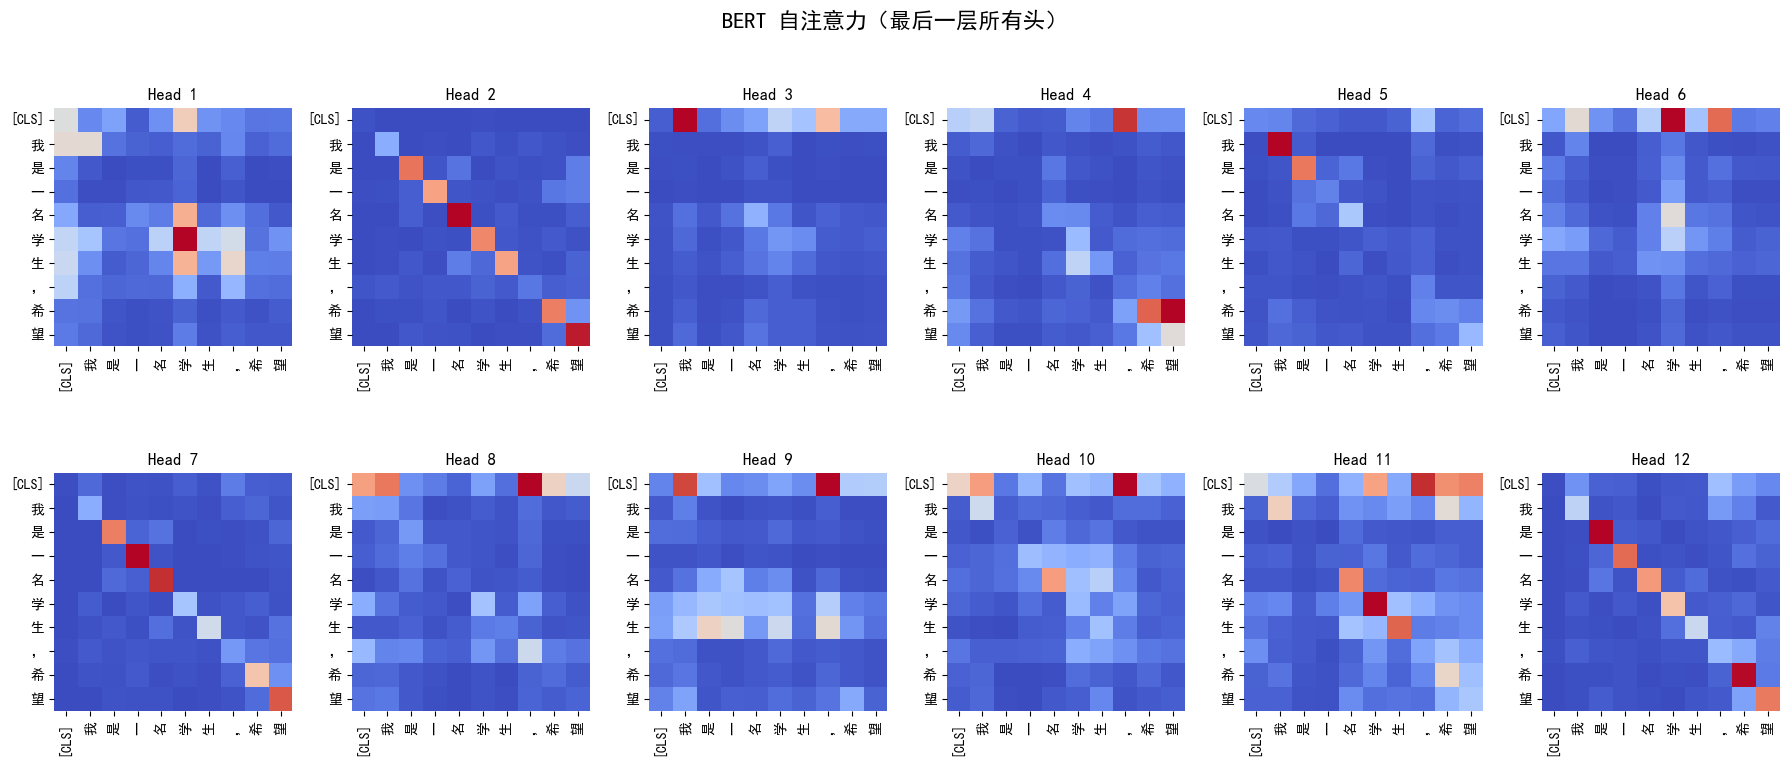

In [79]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns

# 加载模型和分词器
model = BertModel.from_pretrained("bert-base-chinese", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

# 输入文本
text = "我 是 一名 学生，希望 能 掌握 transformer 的 自注意力机制。"
inputs = tokenizer(text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# 获取注意力
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # list: [layer][batch, heads, seq_len, seq_len]

# 选择最后一层、前 10 个 token
layer = -1
head_num = len(attentions[layer][0])
max_tokens = 10
attn = attentions[layer][0, :, :max_tokens, :max_tokens]  # [heads, seq_len, seq_len]
tokens = tokens[:max_tokens]

# 可视化所有注意力头
fig, axes = plt.subplots(2, head_num // 2, figsize=(18, 8))
for i in range(head_num):
    ax = axes[i // (head_num // 2), i % (head_num // 2)]
    sns.heatmap(attn[i].numpy(), xticklabels=tokens, yticklabels=tokens,
                cmap="coolwarm", cbar=False, square=True, annot=False, ax=ax)
    ax.set_title(f"Head {i+1}")
plt.suptitle("BERT 自注意力（最后一层所有头）", fontsize=16)
plt.tight_layout()
plt.show()
